### Anserini

In [29]:
# %%capture
# !pip install pyserini==0.8.1.0
# !pip install transformers

import json
import os
import torch
import numpy
from tqdm.notebook import tqdm
from transformers import *
import warnings
import glob
import os
import jsonlines
import re
import xml.etree.ElementTree as ET
from elasticsearch import Elasticsearch
import re
from collections import defaultdict
import numpy as np
from scipy import spatial
import numpy as np
import gc
import math
import torch
from transformers import *
import pandas as pd
import warnings
import time

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

ARQ_INDEX = '/data/szr207/dataset/ArqMath/anserini_index'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-11.0.7.10-4.el7_8.x86_64"
topic_file_path = "/data/szr207/dataset/ArqMath/Task1/Topics/Topics_V2.0.xml"
# topic_file_path = "/data/szr207/dataset/ArqMath/Task1/Sample Topics/Task1_Samples_V2.0.xml"
model_path = "/data/szr207/github/transformers/examples/language-modeling/output/checkpoint-4000000"

from pyserini.search import pysearch

class Topic:
    """
    This class shows a topic for task 1. Each topic has an topic_id which is str, a title and question which
    is the question body and a list of tags.
    """

    def __init__(self, topic_id, title, question, tags):
        self.topic_id = topic_id
        self.title = title
        self.question = question
        self.lst_tags = tags


class TopicReader:
    """
    This class takes in the topic file path and read all the topics into a map. The key in this map is the topic id
    and the values are Topic which has 4 attributes: id, title, question and list of tags for each topic.

    To see each topic, use the get_topic method, which takes the topic id and return the topic in Topic object and
    you have access to the 4 attributes mentioned above.
    """

    def __init__(self, topic_file_path):
        self.__map_topics = self.__read_topics(topic_file_path)

    def __read_topics(self, topic_file_path):
        map_topics = {}
        tree = ET.parse(topic_file_path)
        root = tree.getroot()
        for child in root:
            topic_id = child.attrib['number']
            title = child[0].text
            question = child[1].text
            lst_tag = child[2].text.split(",")
            map_topics[topic_id] = Topic(topic_id, title, question, lst_tag)
        return map_topics

    def get_topic(self, topic_id):
        if topic_id in self.__map_topics:
            return self.__map_topics[topic_id]
        return None


queries = []
#"In this example, the title and the question body of topic with id A.1 is printed."
topic_reader = TopicReader(topic_file_path)
dict_q_a = defaultdict(list)

searcher = pysearch.SimpleSearcher(ARQ_INDEX)


topic_list = []
with open('../runs/qrel_task1', 'r') as eval_file:
    for _,line in enumerate(eval_file):
        topic_list.append(line.split('\t')[0])

topic_list = list(set(topic_list))

anserini_time_list = []

# with open('tf.psu-task1-prim.anserini-auto-both-A.tsv', 'w') as eval_file:
for topic_id in tqdm(topic_list):
#         if topic_id in topic_list:
#         topic_id = 'A.4'
    title = re.sub('<[^<]+?>', '', topic_reader.get_topic(topic_id).title)
    body = topic_reader.get_topic(topic_id).question
    body_pro = re.sub('<[^<]+?>', '', body)
    query = title + '. ' + body_pro
    queries.append(query)
#     print(topic_id, query[:80], '...')
    tic = time.perf_counter()
    hits = searcher.search(query,1000)
    toc = time.perf_counter()
    anserini_time_list.append((topic_id,toc - tic))
    
    for hit in hits:
#         if hit.docid in list_p:
#             eval_file.write(topic_id+'\t'+ '1\t' +str(hit.docid)+'\t'+str(count)+'\t'+ str(hit.score)+'\t'+ 'anserini'+'\n')
#             count+=1
            dict_q_a[topic_id].append(hit)

In [30]:
sorted_by_second = sorted(anserini_time_list, key=lambda tup: tup[1])
print("Longest time: ",sorted_by_second[-1])
print("Shortest time: ",sorted_by_second[0])

Longest time:  ('A.47', 2.5889229811728)
Shortest time:  ('A.88', 0.148848757147789)


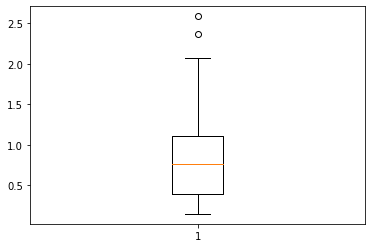

In [32]:
ans_times = []
for idx, t in anserini_time_list:
    ans_times.append(t)
    
import matplotlib.pyplot as plt
x = ans_times
plt.boxplot(x)
plt.show()

In [14]:
import glob
from tqdm.notebook import tqdm
import os
import jsonlines
import re
import xml.etree.ElementTree as ET
from elasticsearch import Elasticsearch
import re
from collections import defaultdict
import numpy as np
from scipy import spatial
import numpy as np
import gc
import math
import torch
from transformers import *
from transformers import pipeline

model_path = "/data/szr207/github/transformers/examples/language-modeling/output/checkpoint-3000000"
ques_path = '/data/szr207/dataset/ArqMath/jsons/questions/all.ques.jsonl'
ans_path = '/data/szr207/dataset/ArqMath/jsons/answers/all.ans.jsonl'
topic_file_path = "/data/szr207/dataset/ArqMath/Task1/Topics/Topics_V2.0.xml"

class Topic:
    """
    This class shows a topic for task 1. Each topic has an topic_id which is str, a title and question which
    is the question body and a list of tags.
    """

    def __init__(self, topic_id, title, question, tags):
        self.topic_id = topic_id
        self.title = title
        self.question = question
        self.lst_tags = tags


class TopicReader:
    """
    This class takes in the topic file path and read all the topics into a map. The key in this map is the topic id
    and the values are Topic which has 4 attributes: id, title, question and list of tags for each topic.

    To see each topic, use the get_topic method, which takes the topic id and return the topic in Topic object and
    you have access to the 4 attributes mentioned above.
    """

    def __init__(self, topic_file_path):
        self.__map_topics = self.__read_topics(topic_file_path)

    def __read_topics(self, topic_file_path):
        map_topics = {}
        tree = ET.parse(topic_file_path)
        root = tree.getroot()
        for child in root:
            topic_id = child.attrib['number']
            title = child[0].text
            question = child[1].text
            lst_tag = child[2].text.split(",")
            map_topics[topic_id] = Topic(topic_id, title, question, lst_tag)
        return map_topics

    def get_topic(self, topic_id):
        if topic_id in self.__map_topics:
            return self.__map_topics[topic_id]
        return None

def remove_stop(query):
    with open('englishST.txt') as f:
        all_stopwords = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    all_stopwords = [x.strip() for x in all_stopwords] 
    text_tokens = query.split(' ')
    query = [word for word in text_tokens if not word in all_stopwords]
    query = ' '.join(query)
    return query

def remove_punct(my_str):
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    # To take input from the user
    # my_str = input("Enter a string: ")

    # remove punctuation from the string
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct

es = Elasticsearch(['http://csxindex05:9200/'], verify_certs=True)
queries = []
#"In this example, the title and the question body of topic with id A.1 is printed."
topic_reader = TopicReader(topic_file_path)
dict_q_a = defaultdict(list)

topic_list = []
with open('../runs/qrel_task1', 'r') as eval_file:
    for _,line in enumerate(eval_file):
        topic_list.append(line.split('\t')[0])

topic_list = list(set(topic_list))

time_list = []

for topic_id in tqdm(topic_list):
    title = re.sub('<[^<]+?>', '', topic_reader.get_topic(topic_id).title)
    body = topic_reader.get_topic(topic_id).question
    body_pro = re.sub('<[^<]+?>', '', body)
    query = title + '. ' + body_pro
    queries.append(query)
    query = query.lower()
    query = remove_stop(query)
#     print(topic_id, query)
    body = {
        "size": 1000,
         "query": {
               "more_like_this" : {
            "fields" : ["body"],
            "like" : query,
        }
        }
    }
    tic = time.perf_counter()
    res = es.search(index="arq_ans_ques", body=body, request_timeout=1000)
    toc = time.perf_counter()
    
    time_list.append((topic_id,toc - tic))
    
    for result in res['hits']['hits']:
        dict_q_a[topic_id].append(result['_source']['post_id'])

In [20]:
sorted_by_second = sorted(time_list, key=lambda tup: tup[1])
print("Longest time: ",sorted_by_second[-1])
print("Shortest time: ",sorted_by_second[0])

Longest time:  ('A.87', 1.2058666124939919)
Shortest time:  ('A.39', 0.14096404984593391)


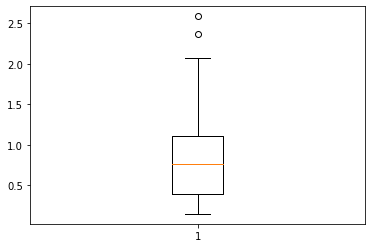

In [34]:
times = []
for idx, t in time_list:
    times.append(t)
    
import matplotlib.pyplot as plt
data = [ans_times, times]
plt.boxplot(x)
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f82eff82f50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f82eff82790>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f82eff921d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f82effafd90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f82effafe90>,
 'means': []}

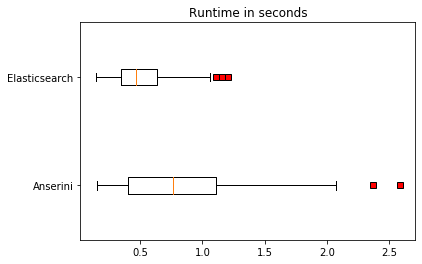

In [35]:
red_square = dict(markerfacecolor='r', marker='s')
fig5, ax5 = plt.subplots()
ax5.set_title('Runtime in seconds')
ax5.boxplot(data, vert=False, flierprops=red_square, labels=['Anserini', 'Elasticsearch'])

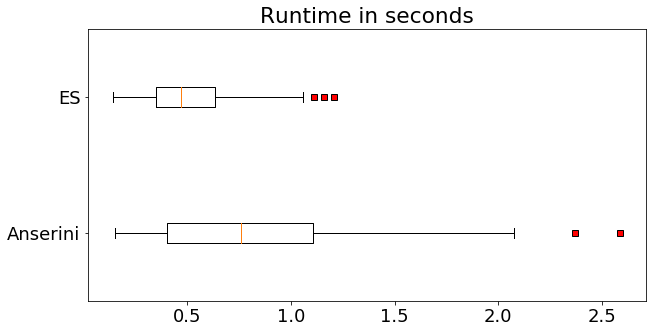

In [132]:
red_square = dict(markerfacecolor='r', marker='s')
fig5, ax5 = plt.subplots()
ax5.set_title('Runtime in seconds')
plt.rcParams.update({'font.size': 16})

ax5.boxplot(data, vert=False, flierprops=red_square, labels=['Anserini', 'ES'])
fig5.set_size_inches(10,5)
plt.savefig('run_times.pdf')

Found 10 runs in path /data/szr207/projects/ArqMath/notebooks/final_runs


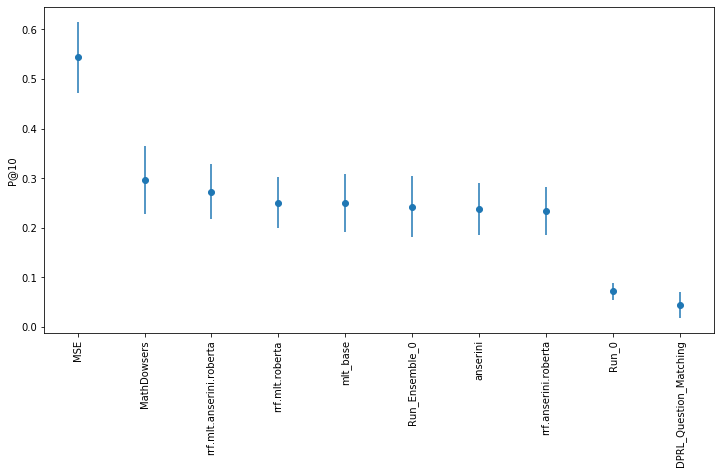

In [84]:
from trectools import TrecQrel, procedures

qrels_file = "../runs/qrel_task1"
qrels = TrecQrel(qrels_file)

# Generates a P@10 graph with all the runs in a directory
path_to_runs = "/data/szr207/projects/ArqMath/notebooks/final_runs"
runs = procedures.list_of_runs_from_path(path_to_runs, "*.tsv")

results = procedures.evaluate_runs(runs, qrels, per_query=True)
p10 = procedures.extract_metric_from_results(results, "P_10")
fig = procedures.plot_system_rank(p10, display_metric="P@10", outfile="plot.pdf")
fig.savefig("plot.pdf", bbox_inches='tight', dpi=600)
# Sample output with one run for each participating team in robust03:

#### Our system has the highest Recall

Found 4 runs in path /data/szr207/projects/ArqMath/notebooks/final_runs/recall


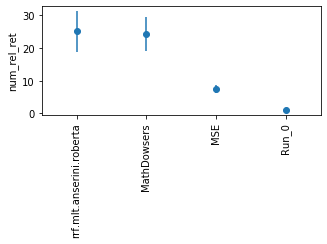

In [98]:
from trectools import TrecQrel, procedures

qrels_file = "../runs/qrel_task1"
qrels = TrecQrel(qrels_file)

# Generates a P@10 graph with all the runs in a directory
path_to_runs = "/data/szr207/projects/ArqMath/notebooks/final_runs"
runs = procedures.list_of_runs_from_path(path_to_runs, "*.tsv")

results = procedures.evaluate_runs(runs, qrels, per_query=True)
p10 = procedures.extract_metric_from_results(results, "num_rel_ret")
fig = procedures.plot_system_rank(p10, display_metric="num_rel_ret", outfile="plot.pdf")
fig.set_size_inches(5,2)
fig.savefig("plot.pdf", bbox_inches='tight', dpi=600)
# Sample output with one run for each participating team in robust03:

Found 5 runs in path /data/szr207/projects/ArqMath/notebooks/final_runs/recall


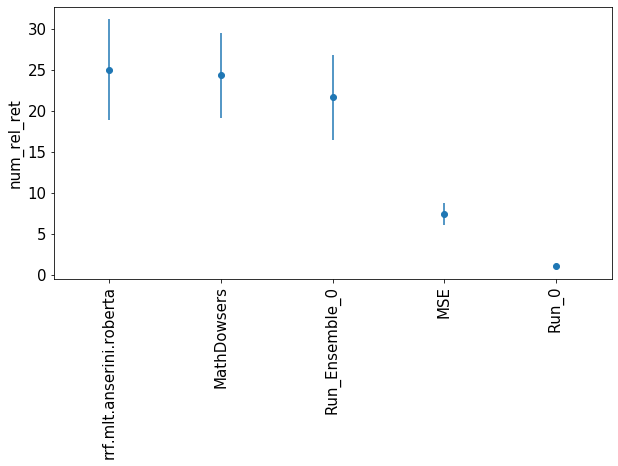

In [136]:
from trectools import TrecQrel, procedures
import matplotlib.pyplot as plt

qrels_file = "../runs/qrel_task1"
qrels = TrecQrel(qrels_file)

# Generates a P@10 graph with all the runs in a directory
path_to_runs = "/data/szr207/projects/ArqMath/notebooks/final_runs/recall"
runs = procedures.list_of_runs_from_path(path_to_runs, "*.tsv")
plt.rcParams.update({'font.size': 15})

results = procedures.evaluate_runs(runs, qrels, per_query=True)
p10 = procedures.extract_metric_from_results(results, "num_rel_ret")
fig = procedures.plot_system_rank(p10, display_metric="num_rel_ret", outfile="plot.pdf")
fig.set_size_inches(10,5)
fig.savefig("recal_plot.pdf", bbox_inches='tight', dpi=600)
# Sample output with one run for each participating team in robust03:

Found 10 runs in path /data/szr207/projects/ArqMath/notebooks/final_runs


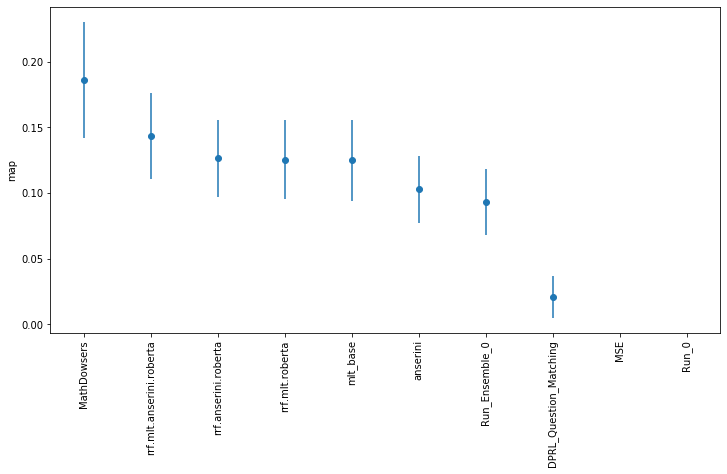

In [81]:
from trectools import TrecQrel, procedures

qrels_file = "../runs/qrel_task1"
qrels = TrecQrel(qrels_file)

# Generates a P@10 graph with all the runs in a directory
path_to_runs = "/data/szr207/projects/ArqMath/notebooks/final_runs"
runs = procedures.list_of_runs_from_path(path_to_runs, "*.tsv")

results = procedures.evaluate_runs(runs, qrels, per_query=True)
p10 = procedures.extract_metric_from_results(results, "map")
fig = procedures.plot_system_rank(p10, display_metric="map", outfile="plot.pdf")
fig.savefig("plot.pdf", bbox_inches='tight', dpi=600)
# Sample output with one run for each participating team in robust03:

Found 10 runs in path /data/szr207/projects/ArqMath/notebooks/final_runs


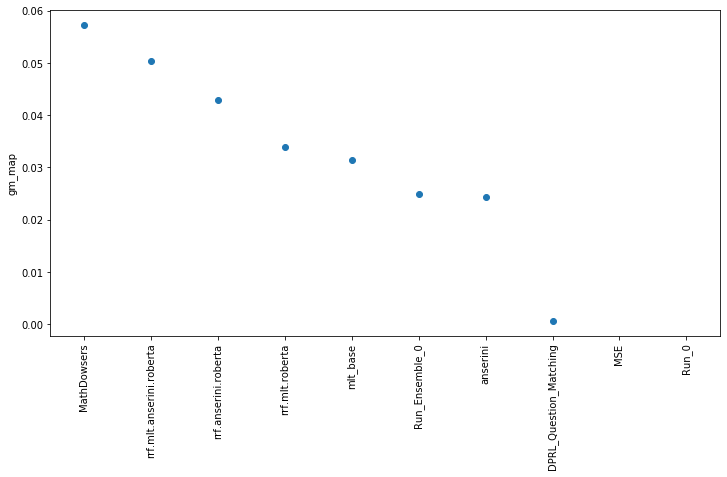

In [82]:
from trectools import TrecQrel, procedures

qrels_file = "../runs/qrel_task1"
qrels = TrecQrel(qrels_file)

# Generates a P@10 graph with all the runs in a directory
path_to_runs = "/data/szr207/projects/ArqMath/notebooks/final_runs"
runs = procedures.list_of_runs_from_path(path_to_runs, "*.tsv")

results = procedures.evaluate_runs(runs, qrels, per_query=True)
p10 = procedures.extract_metric_from_results(results, "gm_map")
fig = procedures.plot_system_rank(p10, display_metric="gm_map", outfile="plot.pdf")
fig.savefig("plot.pdf", bbox_inches='tight', dpi=600)
# Sample output with one run for each participating team in robust03:

In [ ]:
! java -jar jtreceval-0.0.5-jar-with-dependencies.jar -l2 -m num_rel_ret  ../runs/qrel_task1 tf.psu-task1-prim.roberta-base-auto-both-A.tsv